In [1]:
import pm4py
import pandas as pd
import datetime
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import random
import seaborn as sns
from IPython import display

# What is it about
## Data
We have data of processes - `bpi12`. It is a sequence of (`time_stamp`, `activity`,...) 
and other stuff which is not considered by community. Basicly here it is `BPI_Challenge_2012.xes`

In [2]:
file_path = 'datasets/BPI_Challenge_2012.xes'
event_log = pm4py.read_xes(file_path)
df = pm4py.convert_to_dataframe(event_log)
df

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
3,112,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
4,NaN,START,W_Completeren aanvraag,2011-10-01 11:36:46.437000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
...,...,...,...,...,...,...,...
262195,112,COMPLETE,A_PARTLYSUBMITTED,2012-02-29 23:51:17.423000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000
262196,112,SCHEDULE,W_Afhandelen leads,2012-02-29 23:52:01.287000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000
262197,11169,START,W_Afhandelen leads,2012-03-01 09:26:46.736000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000
262198,11169,COMPLETE,A_DECLINED,2012-03-01 09:27:37.118000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000


We works only wuith activity adn time

In [3]:
df = pm4py.convert_to_dataframe(event_log)
#df = df[df['lifecycle:transition']=='COMPLETE']
df = df[['time:timestamp', 'case:concept:name', 'concept:name']]
df = df.rename(columns={'time:timestamp': 'timestamp', 'case:concept:name': 'trace_id', 'concept:name': 'activity'})
df['trace_id'] = df['trace_id'].apply(lambda x: int(x))
df.to_csv('datasets/bpi_12.csv', index=False)
df

,timestamp,trace_id,activity
0,2011-10-01 00:38:44.546000+02:00,173688,A_SUBMITTED
1,2011-10-01 00:38:44.880000+02:00,173688,A_PARTLYSUBMITTED
2,2011-10-01 00:39:37.906000+02:00,173688,A_PREACCEPTED
3,2011-10-01 00:39:38.875000+02:00,173688,W_Completeren aanvraag
4,2011-10-01 11:36:46.437000+02:00,173688,W_Completeren aanvraag
...,...,...,...
262195,2012-02-29 23:51:17.423000+01:00,214376,A_PARTLYSUBMITTED
262196,2012-02-29 23:52:01.287000+01:00,214376,W_Afhandelen leads
262197,2012-03-01 09:26:46.736000+01:00,214376,W_Afhandelen leads
262198,2012-03-01 09:27:37.118000+01:00,214376,A_DECLINED


Some defenitions must be mentioned:
- event ($e_i$) - {`activity` ($a$), `time_stamp` ($t$)}
- trace (t) - $[e_1,\ e_2, \dots]$

## Purpose
Main objective - predict next `time_stamp` and `activity`. 

For activity metric, used by community is accuracy, and in latest works `f1`. For `time_stamp` ussualy MAE, sometimes weighted MAE.

Nevetheless some other objectives are discovered - whole trace prediction. The metric for activity prediction - Damerau-Levenshtein Similarity

# Visualization
## Activity transition
Firstly let's take a look on all activities transition  and try to estimate $P(a_{i+1} | a_i)$. It is a square matrix, which worth to be presented as `sns.heatmap`

In [4]:
activities = list(set(df['activity'].values))
n_act = len(activities)
traces = list(set(df['trace_id'].values))
_df = df.copy()
_df['activity_next'] = _df['activity'].shift(1)
_df['trace_id_next'] = _df['trace_id'].shift(1)
_df = _df.dropna()
_df = _df[_df['trace_id_next'] == _df['trace_id']]

In [5]:

transitions_counts = np.zeros((n_act, n_act))
nums_of_ac_next = []
for _i_next, act_next in enumerate(activities):
    _df_ac_next = _df[_df['activity_next'] == act_next]
    nums_of_ac_next.append(_df_ac_next.shape[0])
    for _i, act in enumerate(activities):
        transitions_counts[_i_next, _i] += _df_ac_next[_df_ac_next['activity'] == act].shape[0]

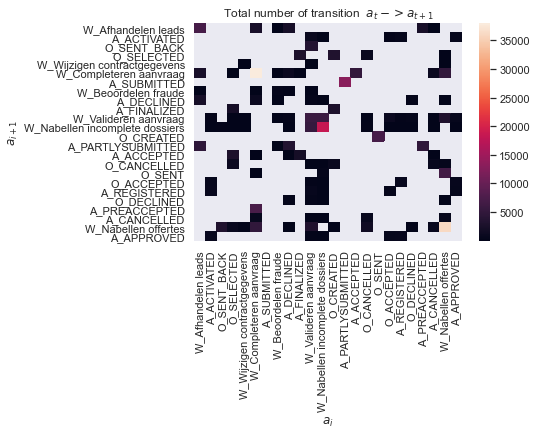

In [6]:
transitions_counts[transitions_counts == 0] = np.nan
sns.set(rc={'figure.facecolor':'white'})
sns.heatmap(transitions_counts, xticklabels=list(activities), yticklabels=list(activities))
plt.title('Total number of transition  $a_t -> a_{t+1}$')

plt.xlabel('$a_i$')
plt.ylabel('$a_{i+1}$')
plt.show()

In [7]:
print(f'There are {np.isnan(transitions_counts).sum()} not existing transitions')

There are 451 not existing transitions


In [8]:
transitions_counts[transitions_counts < 10] = np.nan

<ipython-input-8-6ef5bc085097>:1: RuntimeWarning: invalid value encountered in less
  transitions_counts[transitions_counts < 10] = np.nan


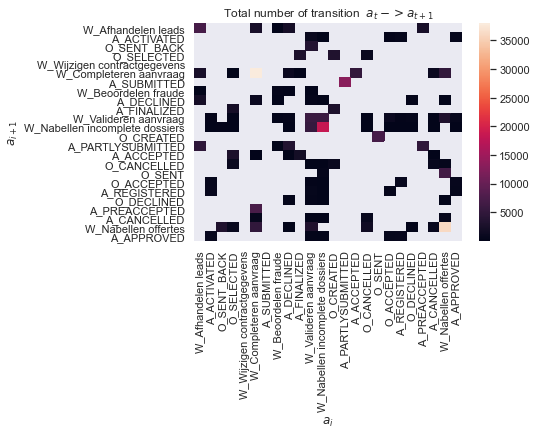

In [9]:
sns.set(rc={'figure.facecolor':'white'})
sns.heatmap(transitions_counts, xticklabels=list(activities), yticklabels=list(activities))
plt.title('Total number of transition  $a_t -> a_{t+1}$')

plt.xlabel('$a_i$')
plt.ylabel('$a_{i+1}$')
plt.show()

In [10]:
print(f'There are {np.isnan(transitions_counts).sum()} not existing transitions')

There are 463 not existing transitions


Cant say there are much rare transitions

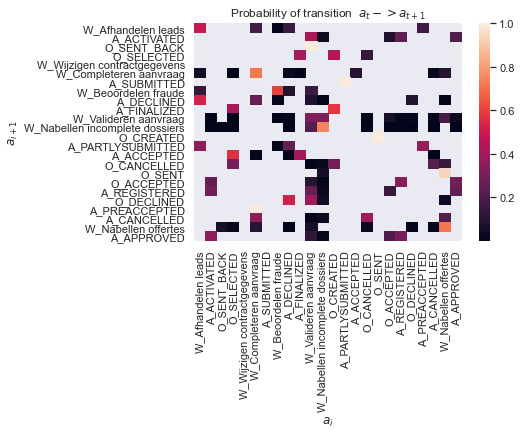

In [11]:
sns.set(rc={'figure.facecolor':'white'})
sns.heatmap(transitions_counts / np.array(nums_of_ac_next).reshape((-1, 1)),
            xticklabels=list(activities), yticklabels=list(activities))
plt.title('Probability of transition  $a_t -> a_{t+1}$')
plt.xlabel('$a_i$')
plt.ylabel('$a_{i+1}$')
plt.show()

Can't say this dataset has uniform distribution.

## Time features
For leveraging predictive models the following features are created:
- $t_e$ - time since previous event
- $t_w$ - time since the beginning of week
- $t_t$ - time since the beginning of trace

let's visualize all these features

In [12]:
import rl4pm_lib.preprocessing as preprocessing

prepro = preprocessing.DfPreprocesser()
prepro.fit(df)
df_preprocessed = prepro.transform(df)
df_preprocessed.to_csv('bpi_12_preprocessed.csv', index=False)
df_preprocessed

,tt,te,tw,trace_id,A_ACCEPTED,A_ACTIVATED,A_APPROVED,A_CANCELLED,A_DECLINED,A_FINALIZED,...,O_SELECTED,O_SENT,O_SENT_BACK,W_Afhandelen leads,W_Beoordelen fraude,W_Completeren aanvraag,W_Nabellen incomplete dossiers,W_Nabellen offertes,W_Valideren aanvraag,W_Wijzigen contractgegevens
0,0.000,0.000,434324.546,173688,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.334,0.334,434324.880,173688,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,53.360,53.026,434377.906,173688,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,54.329,0.969,434378.875,173688,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,39481.891,39427.562,473806.437,173688,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262195,0.624,0.624,258677.423,214376,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
262196,44.488,43.864,258721.287,214376,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
262197,34529.937,34485.449,293206.736,214376,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
262198,34580.319,50.382,293257.118,214376,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


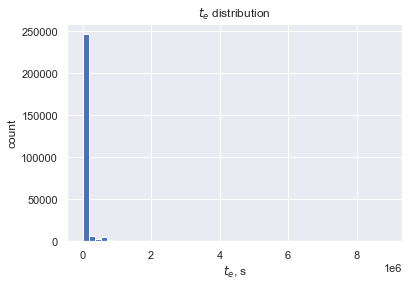

In [13]:
plt.hist(df_preprocessed['te'].values, bins=50)
plt.title('$t_e$ distribution')
plt.xlabel('$t_e$, s')
plt.ylabel('count')
plt.show()

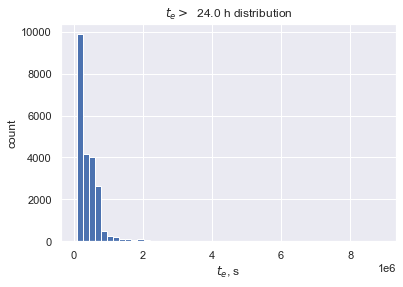

In [14]:
low_bond = 24 *  60 * 60
plt.hist(df_preprocessed[df_preprocessed['te'] > low_bond]['te'].values, bins=50)
plt.title(f'$t_e >$ {low_bond / 60 / 60: .1f} h distribution')
plt.xlabel('$t_e$, s')
plt.ylabel('count')
plt.show()

This distribution is far from uniform too

In [15]:
for quant in [0.9, 0.95, 0.97, 0.99]:
    print(f'{quant * 100} % of $te$ are less then {np.quantile(df_preprocessed["te"].values, quant) / (60 * 60): .2f} h')

90.0 % of $te$ are less then  18.29 h
95.0 % of $te$ are less then  68.93 h
97.0 % of $te$ are less then  124.59 h
99.0 % of $te$ are less then  188.92 h


## What is wrong with this visualization
- transition matrix has a lot of `nan`
- Whant to see which transitions lead to high $t_e$ 
### SberProcessMining
Let's use [this](https://github.com/SberProcessMining/Sber_Process_Mining) repo to got a nice visualization

In [16]:
from sberpm import DataHolder

In [17]:
data_holder = DataHolder(data=df, 
                         id_column='trace_id', 
                         activity_column='activity', 
                         start_timestamp_column='timestamp')

c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\sberpm\_holder.py:307: UserWarning: DataHolder: 'time_format' is not set, recommended to specify it for correct time conversion, e.g., time_format='%d-%m-%Y %H:%M:%S'
  warnings.warn("DataHolder: 'time_format' is not set, "
c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\sberpm\_holder.py:339: UserWarning: DataHolder: timestamp auto conversion will be done. 'dayfirst' is not set, in ambiguous cases it will be considered as False.
  warnings.warn(f"DataHolder: timestamp auto conversion will be done. '{argument}' "
c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\sberpm\_holder.py:339: UserWarning: DataHolder: timestamp auto conversion will be done. 'yearfirst' is not set, in ambiguous cases it will be considered as False.
  warnings.warn(f"DataHolder: timestamp auto conversion will be done. '{argument}' "


Strange warnings. It read all right, enven pandas can read datetime with no additional formats, so why does it nedd it, dunno

In [18]:
data_holder.data.head(3)

,timestamp,trace_id,activity
0,2011-09-30 22:38:44.546000+00:00,173688,A_SUBMITTED
1,2011-09-30 22:38:44.880000+00:00,173688,A_PARTLYSUBMITTED
2,2011-09-30 22:39:37.906000+00:00,173688,A_PREACCEPTED


In [19]:
from sberpm.autoinsights import AutoInsights
from sberpm.miners import SimpleMiner
from sberpm.visual import GraphvizPainter

the longest-lasting transitions are colored red

In [20]:
auto_i = AutoInsights(data_holder, time_unit='day')
simple_miner = SimpleMiner(data_holder)
simple_miner.apply()
auto_i.apply(miner=simple_miner, mode='time')
graph = auto_i.get_graph()

painter = GraphvizPainter()
painter.apply_insights(graph)
painter.show()

all transitions are given a status:
- Optimal (positive insights)
- (negative insights)

In [21]:
auto_i = AutoInsights(data_holder, time_unit='day')
simple_miner = SimpleMiner(data_holder)
simple_miner.apply()
auto_i.apply(miner=simple_miner, mode='overall')
graph = auto_i.get_graph()

painter = GraphvizPainter()
painter.apply_insights(graph)
painter.show()

## Max $t_e$ & trace len

In [22]:
df_preprocessed

,tt,te,tw,trace_id,A_ACCEPTED,A_ACTIVATED,A_APPROVED,A_CANCELLED,A_DECLINED,A_FINALIZED,...,O_SELECTED,O_SENT,O_SENT_BACK,W_Afhandelen leads,W_Beoordelen fraude,W_Completeren aanvraag,W_Nabellen incomplete dossiers,W_Nabellen offertes,W_Valideren aanvraag,W_Wijzigen contractgegevens
0,0.000,0.000,434324.546,173688,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.334,0.334,434324.880,173688,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,53.360,53.026,434377.906,173688,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,54.329,0.969,434378.875,173688,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,39481.891,39427.562,473806.437,173688,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262195,0.624,0.624,258677.423,214376,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
262196,44.488,43.864,258721.287,214376,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
262197,34529.937,34485.449,293206.736,214376,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
262198,34580.319,50.382,293257.118,214376,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
traces_te_max = {}
traces_len = {}
for t_id in df_preprocessed['trace_id'].values:
    _d = df_preprocessed[df_preprocessed['trace_id'] == t_id]
    traces_len[t_id] = _d.shape[0]
    traces_te_max[t_id] = _d['te'].max()

Text(0, 0.5, 'max trace length')

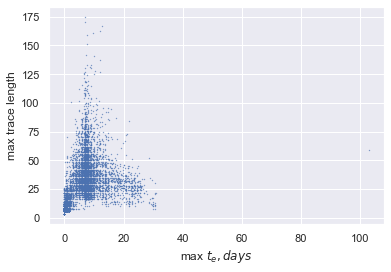

In [24]:
plt.scatter(np.array(list(traces_te_max.values())) / 3600 / 24, traces_len.values(), s=0.1)
plt.xlabel('max $t_e, days$')
plt.ylabel('max trace length')

Можно убрать все `trace` в которых есть $t_e$ длиннее `33`дней и которые в себе насчитывают более `100` процессов 

Ожидаются следующие улучшения:
- улучшится масштабирование времени и улучшется качество
- меньше ресурсов в нейросетевых подходах

In [25]:
MAX_TE = 33 * 24 * 60 * 60
MAX_TRACE_LEN = 100

# Loops
На рисунке были видны циклы.
Это плохо. Если мы использаем для обучения окна длиннйо 2, то возникает проблема:

$A \rightarrow B \rightarrow A \rightarrow B \rightarrow A \dots A \rightarrow B \rightarrow C$

сформируют признаки

$$[A,\ B],\ [A]$$
$$[B,\ A],\ [B]$$
$$[A,\ B],\ [A]$$
$$\dots$$

и не получится обучить что после $[A,\ B]$ идёт $[C]$

## Какие циклы?
Чтобы сильно не париться, будем искать циклы $A \rightarrow B \rightarrow A$. Отметим `trace_id` с циклами

In [41]:
def is_there_cycle(x) -> bool:
    out = None
    if len(x) < 3:
        out = False
    else:
        out = False
        _i = 0
        l = len(x)
        while (not out) and (_i + 2 <= l - 1):
            if (x[_i] == x[_i+2]): # or (x[_i] == x[_i+1]):
                out = True
            _i += 1
    return out

In [59]:
def number_of_cycles(x) -> int:
    out = 0
    if len(x) < 3:
        out = 0
    else:
        out = 0
        _i = 0
        l = len(x)
        while (_i + 2 <= l - 1):
            if (x[_i] == x[_i+2]) or (x[_i] == x[_i+1]):
                out += 1
            _i += 1
    return out

In [50]:
assert is_there_cycle([1, 2, 3, 2]) == True
assert is_there_cycle([1, 2, 3]) == False
# assert is_there_cycle([1, 2, 3, 3, 5, 6]) == True
assert is_there_cycle([1, 2, 3, 4, 5, 6]) == False

In [51]:
traces_is_cycle = {}
for t_id in df_preprocessed['trace_id'].values:
    _d = df[df['trace_id'] == t_id]
    traces_is_cycle[t_id] = is_there_cycle(_d['activity'].values)

In [57]:
print(f'{np.array(list(traces_is_cycle.values())).sum() / len(traces_is_cycle) * 100: .2f}% of all traces got cycles')

 73.63% of all traces got cycles


Ужас, нельзя просто выкинуть все процессы с циклами.

In [60]:
traces_num_cycles = {}
for t_id in df_preprocessed['trace_id'].values:
    _d = df[df['trace_id'] == t_id]
    traces_num_cycles[t_id] = number_of_cycles(_d['activity'].values)

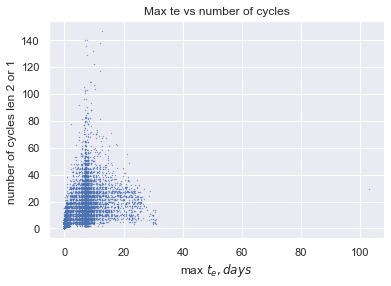

In [61]:
plt.scatter(np.array(list(traces_te_max.values())) / 3600 / 24, traces_num_cycles.values(), s=0.1)
plt.xlabel('max $t_e, days$')
plt.ylabel('number of cycles len 2 or 1 ')
plt.title('Max te vs number of cycles')
plt.show()

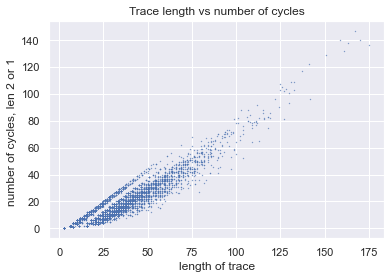

In [69]:
plt.scatter(list(traces_len.values()), traces_num_cycles.values(), s=0.1)
plt.xlabel('length of trace')
plt.ylabel('number of cycles, len 2 or 1 ')
plt.title('Trace length vs number of cycles')
plt.show()

Так они ещё и сильно коррелируют!

In [72]:
traces_len

{173688: 26,
 173691: 39,
 173694: 59,
 173697: 3,
 173700: 3,
 173703: 9,
 173706: 14,
 173709: 12,
 173712: 14,
 173715: 24,
 173718: 77,
 173721: 35,
 173724: 20,
 173727: 3,
 173730: 76,
 173733: 6,
 173736: 55,
 173739: 48,
 173742: 40,
 173745: 19,
 173748: 38,
 173751: 24,
 173754: 42,
 173757: 3,
 173760: 26,
 173763: 6,
 173766: 29,
 173769: 3,
 173772: 3,
 173775: 9,
 173778: 6,
 173781: 7,
 173784: 108,
 173787: 35,
 173790: 28,
 173793: 36,
 173796: 20,
 173799: 13,
 173802: 6,
 173805: 41,
 173808: 3,
 173811: 48,
 173814: 10,
 173817: 29,
 173820: 3,
 173823: 24,
 173826: 20,
 173829: 12,
 173832: 3,
 173835: 30,
 173838: 3,
 173841: 11,
 173844: 26,
 173847: 20,
 173850: 3,
 173853: 3,
 173856: 8,
 173859: 21,
 173862: 6,
 173865: 3,
 173868: 28,
 173871: 36,
 173874: 3,
 173877: 3,
 173880: 61,
 173883: 3,
 173886: 3,
 173889: 6,
 173892: 3,
 173895: 3,
 173898: 27,
 173901: 6,
 173904: 6,
 173907: 3,
 173910: 3,
 173913: 28,
 173916: 10,
 173919: 18,
 173922: 3,
 17392

In [71]:
df[df['trace_id'] == 173829]

,timestamp,trace_id,activity
1202,2011-10-02 09:54:34.096000+02:00,173829,A_SUBMITTED
1203,2011-10-02 09:54:34.241000+02:00,173829,A_PARTLYSUBMITTED
1204,2011-10-02 09:55:28.525000+02:00,173829,W_Afhandelen leads
1205,2011-10-03 09:17:30.044000+02:00,173829,W_Afhandelen leads
1206,2011-10-03 09:34:55.790000+02:00,173829,W_Afhandelen leads
1207,2011-10-03 09:37:25.560000+02:00,173829,W_Afhandelen leads
1208,2011-10-03 09:37:43.539000+02:00,173829,A_PREACCEPTED
1209,2011-10-03 09:37:44.461000+02:00,173829,W_Completeren aanvraag
1210,2011-10-03 09:37:45.561000+02:00,173829,W_Afhandelen leads
1211,2011-10-03 09:38:04.719000+02:00,173829,W_Completeren aanvraag


In [76]:
df[df['trace_id'] == 173694]

,timestamp,trace_id,activity
65,2011-10-01 08:10:30.287000+02:00,173694,A_SUBMITTED
66,2011-10-01 08:10:30.591000+02:00,173694,A_PARTLYSUBMITTED
67,2011-10-01 08:11:13.026000+02:00,173694,A_PREACCEPTED
68,2011-10-01 08:11:13.390000+02:00,173694,W_Completeren aanvraag
69,2011-10-01 11:31:25.301000+02:00,173694,W_Completeren aanvraag
70,2011-10-01 11:35:59.637000+02:00,173694,W_Completeren aanvraag
71,2011-10-03 11:12:02.445000+02:00,173694,W_Completeren aanvraag
72,2011-10-03 11:21:22.417000+02:00,173694,W_Completeren aanvraag
73,2011-10-03 13:21:06.626000+02:00,173694,W_Completeren aanvraag
74,2011-10-03 13:32:43.313000+02:00,173694,W_Completeren aanvraag


ЖЖЖЖЖесть, в статье про lstm предлагалось забить на требуемую метрику, т.к. она бессмысленна и ее оптимизация приведёт к обучению на константу)))

Была предложена идея выкинуть такие повторяющиеся события.

$[A \rightarrow B \rightarrow B \rightarrow \dots B \rightarrow C] \rightarrow [A \rightarrow B \rightarrow C]$

С точки зрения решения исходной задачи это немного не кегловский опдход, но он может иметь бизнес смысл